In [1]:
# loading libraries

import os
import time

import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from IPython.display import display_html
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
flights_csv = [x for x in os.listdir("./assets/csv/") if x.startswith("flights_")]

In [4]:
flights_csv.sort()

In [5]:
# function to load files

In [6]:
df_cluster = pd.read_csv("./assets/csv/cluster/df_cluster_all_years.csv", sep=",").drop(
    columns=["Unnamed: 0", "year"]
)

In [7]:
df_cluster = df_cluster.groupby(by="icao_origin").sum().reset_index()
df_cluster

,icao_origin,available_seat_km,revenue_pax_km
0,SBAA,3.749310e+05,2.214450e+05
1,SBAC,5.359546e+06,2.740547e+06
2,SBAE,2.258232e+08,1.462803e+08
3,SBAQ,5.299803e+06,3.096486e+06
4,SBAR,9.655877e+09,7.409398e+09
...,...,...,...
241,SWRD,5.834006e+07,4.388815e+07
242,SWSI,4.755653e+08,3.630672e+08
243,SWTP,1.751399e+06,8.988330e+05
244,SWTS,1.262871e+06,5.194930e+05


In [8]:
# function for count

In [9]:
df_count = pd.read_csv("./assets/csv/count/df_count_all_years.csv", sep=",").drop(
    columns="Unnamed: 0"
)

In [10]:
df_count = (
    df_count.groupby("icao_code")
    .sum()
    .sort_values(by="count", ascending=False)
    .reset_index()
)

In [11]:
df_count

,icao_code,count
0,SBGR,818607
1,SBSP,794108
2,SBBR,732100
3,SBKP,554891
4,SBGL,520716
...,...,...
241,SNPY,1
242,SNFO,1
243,SBMT,1
244,SNXB,1


In [12]:
# duplicated airports

In [13]:
same_airport = {
    "SJTC": "SBAE",
    "SBRG": "SJRG",
    "SBCM": "SSIM",
    "SBNT": "SBSG",
    "SBFE": "SDIY",
    "SWRD": "SBRD",
    "SSZW": "SBPG",
    "SSPB": "SBPO",
    "SWSI": "SBSI",
    "SBQV": "SBVC",
    "SBBT": "SNBA",
    "SBGU": "SSGG",
    "SBMH": "SBMG",
    "SBPM": "SBPJ",
    "SNDM": "SBLE",
    "SBMC": "SWIQ",
}

In [14]:
df_cluster["icao_origin"] = df_cluster["icao_origin"].replace(same_airport)

In [15]:
df_cluster = df_cluster.groupby(by="icao_origin").sum().reset_index()

In [16]:
df_cluster = df_cluster.drop(
    df_cluster.index[
        df_cluster["icao_origin"].isin(
            ["SBGS", "SBMT", "SWLF", "SNXB", "SBMM", "SNFO", "SBMN", "SNPY", "SNFE"]
        )
    ],
    axis=0,
)

In [17]:
df_cluster

,icao_origin,available_seat_km,revenue_pax_km
0,SBAA,3.749310e+05,2.214450e+05
1,SBAC,5.359546e+06,2.740547e+06
2,SBAE,2.503321e+08,1.587877e+08
3,SBAQ,5.299803e+06,3.096486e+06
4,SBAR,9.655877e+09,7.409398e+09
...,...,...,...
230,SWPI,9.602442e+07,6.304970e+07
231,SWPY,8.839800e+04,3.942500e+04
232,SWTP,1.751399e+06,8.988330e+05
233,SWTS,1.262871e+06,5.194930e+05


In [18]:
df_count["icao_code"] = df_count["icao_code"].replace(same_airport)

In [19]:
df_count = df_count.groupby(by="icao_code").sum().reset_index()

In [20]:
df_count = df_count.sort_values(by="count", ascending=False)

In [21]:
df_count = df_count.drop(
    df_count.index[
        df_count["icao_code"].isin(
            ["SBGS", "SBMT", "SWLF", "SNXB", "SBMM", "SNFO", "SBMN", "SNPY", "SNFE"]
        )
    ],
    axis=0,
)

In [22]:
df_count

,icao_code,count
39,SBGR,818607
100,SBSP,794108
11,SBBR,732100
58,SBKP,554891
37,SBGL,520716
...,...,...
196,SSLT,5
135,SILC,4
137,SIZX,4
197,SSOE,3


In [23]:
# export to csv

In [24]:
df_cluster.to_csv("./assets/csv/temp/df_cluster.csv", sep=",")

In [25]:
df_count.to_csv("./assets/csv/temp/df_count.csv", sep=",")

# Clustering

In [26]:
# reference

# https://www.kaggle.com/lucaspcarlini/clustering-and-visualisation-using-folium-maps

In [27]:
# clustering flights from 2002 to 2021

In [28]:
flights_all = df_cluster.copy()

## Dendorgram

In [29]:
flights_all_dend = df_cluster.copy().drop(columns=["icao_origin"])

In [30]:
flights_all_dend

,available_seat_km,revenue_pax_km
0,3.749310e+05,2.214450e+05
1,5.359546e+06,2.740547e+06
2,2.503321e+08,1.587877e+08
3,5.299803e+06,3.096486e+06
4,9.655877e+09,7.409398e+09
...,...,...
230,9.602442e+07,6.304970e+07
231,8.839800e+04,3.942500e+04
232,1.751399e+06,8.988330e+05
233,1.262871e+06,5.194930e+05


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 2.86 µs


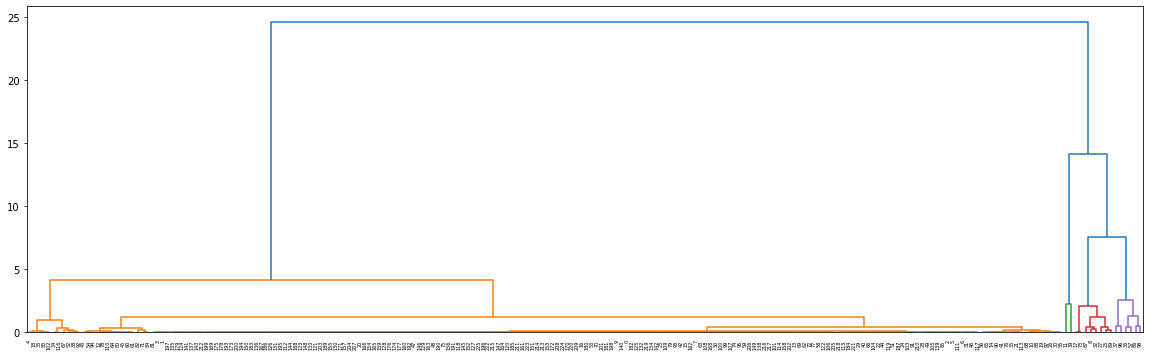

In [31]:
plt.figure(figsize=(20, 6))

X = flights_all_dend
X.shape

dendrogram = hierarchy.dendrogram(
    hierarchy.linkage(StandardScaler().fit_transform(X), method="ward"),
    color_threshold=6,
)

%time

> Although the dendorgram indicated we could go ahead with three clusters, the case with four clusters makes sense too. Therefore, an additional check of visualizing the data may be performed before deciding on the number of clusters.

- x axis represents individual points
- y axis represents the distance or dissimilarity between clusters

- each inverted U represents a cluster divided into its two child clusters
- the width of the U shape represents the distance between the two child clusters
- a wider U, therefore, means that the two child clusters were farther away from each other as compared to a narrower U in the diagram

- drawing a horizontal line at any part of the figure, the number of vertical lines it intersects tells the number of clusters at that stage, and the distance between those vertical lines indicates the inter-cluster distance
- REWRITE it seems that the top three clusters have the highest distances between them

## Clustering Distortion, the Elbow Method

- Definition: mean sum of squared distances to centers

In [32]:
codes = flights_all[["icao_origin"]]
flights_all.drop("icao_origin", axis=1, inplace=True)

In [33]:
distortions = []

K = range(2, 14)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init=50, max_iter=500)
    kmean.fit(flights_all)
    distortions.append(kmean.inertia_)

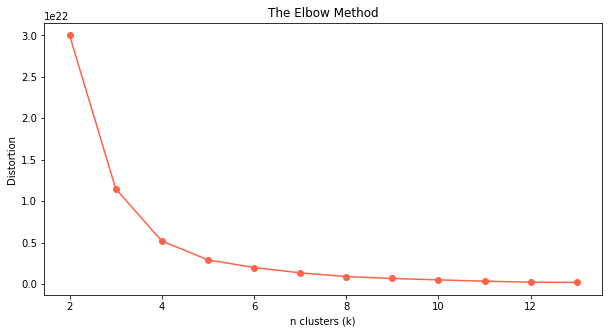

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(2, 14), distortions, "-o", color="tomato")

plt.xlabel("n clusters (k)")
plt.ylabel("Distortion")
plt.title("The Elbow Method");

- distortion decreases sharply from 1 to 3 clusters
- after 6 clusters, gradual decrease with a subsequent increase in number of clusters
- the ideal number of clusters here is therefore, 4

> the elbow method only gives an indication of ideal number of clusters. Occasionally, it may be insufficient to find an optimal k. For instance, the elbow method fails when data is evenly distributed.
> There are other methods to find the optimal number of clusters such as the average silhouette and gap statistic methods. They are indicative methods too, and will not be discussed as a part of this course.

## K-means with 5 clusters

In [35]:
# run k-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(flights_all)

codes["cluster"] = kmeans.labels_

In [36]:
pca = PCA().fit(flights_all)
pca_types = pca.transform(flights_all)
print("Variance explained by each component (%): ")
for i in range(len(pca.explained_variance_ratio_)):
    print("\n", i + 1, "º:", pca.explained_variance_ratio_[i] * 100)
print("Total sum (%): ", sum(pca.explained_variance_ratio_) * 100)
print(
    "Explained variance of the first two components (%): ",
    sum(pca.explained_variance_ratio_[0:1]) * 100,
)

Variance explained by each component (%): 

 1 º: 99.97375533973786

 2 º: 0.026244660262144812
Total sum (%):  100.0
Explained variance of the first two components (%):  99.97375533973786


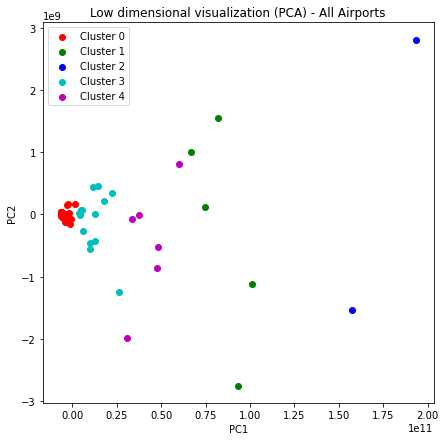

In [37]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []

for i in range(len(pca_types)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_types[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_types[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_types[i])
    if kmeans.labels_[i] == 3:
        c3.append(pca_types[i])
    if kmeans.labels_[i] == 4:
        c4.append(pca_types[i])

c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)
c4 = np.array(c4)

plt.figure(figsize=(7, 7))
plt.scatter(c0[:, 0], c0[:, 1], c="r", label="Cluster 0")
plt.scatter(c1[:, 0], c1[:, 1], c="g", label="Cluster 1")
plt.scatter(c2[:, 0], c2[:, 1], c="b", label="Cluster 2")
plt.scatter(c3[:, 0], c3[:, 1], c="c", label="Cluster 3")
plt.scatter(c4[:, 0], c4[:, 1], c="m", label="Cluster 4")

plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Low dimensional visualization (PCA) - All Airports");

In [38]:
flights_all["cluster"] = kmeans.labels_

flights_all

,available_seat_km,revenue_pax_km,cluster
0,3.749310e+05,2.214450e+05,0
1,5.359546e+06,2.740547e+06,0
2,2.503321e+08,1.587877e+08,0
3,5.299803e+06,3.096486e+06,0
4,9.655877e+09,7.409398e+09,3
...,...,...,...
230,9.602442e+07,6.304970e+07,0
231,8.839800e+04,3.942500e+04,0
232,1.751399e+06,8.988330e+05,0
233,1.262871e+06,5.194930e+05,0


In [39]:
flights_all.groupby("cluster").mean()

,available_seat_km,revenue_pax_km
cluster,,
0,3.672273e+08,2.689577e+08
1,7.174532e+10,5.434936e+10
2,1.441609e+11,1.106443e+11
3,1.448259e+10,1.088226e+10
4,3.956415e+10,2.956701e+10


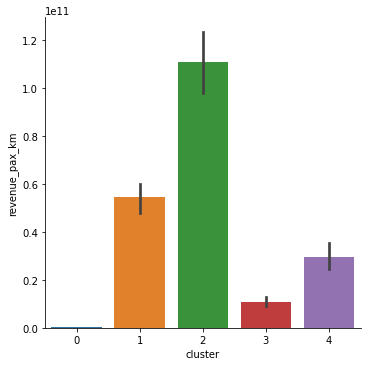

In [40]:
sns.catplot(x="cluster", y="revenue_pax_km", data=flights_all, kind="bar");

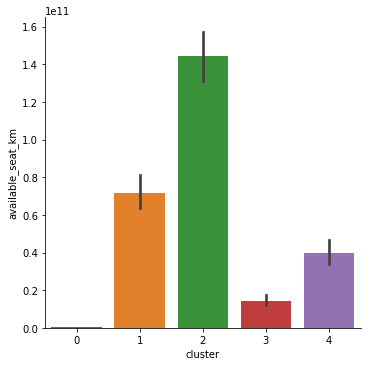

In [41]:
sns.catplot(x="cluster", y="available_seat_km", data=flights_all, kind="bar");

In [42]:
airports_br = pd.read_csv("./assets/csv/airports_brazil.csv", sep=",")

In [43]:
airports = airports_br[
    ["icao_code", "icao_code_old", "lat_dd", "long_dd", "city_primary", "state"]
]
airports

,icao_code,icao_code_old,lat_dd,long_dd,city_primary,state
0,SBAA,NaN,-8.348611,-49.303056,Conceição do araguaia,PA
1,SBAC,NaN,-4.568611,-37.804722,Aracati,CE
2,SBAE,SJTC,-22.157778,-49.068333,Arealva,SP
3,SBAQ,NaN,-21.804444,-48.140278,Araraquara,SP
4,SBAR,NaN,-10.985278,-37.073333,Aracaju,SE
...,...,...,...,...,...,...
227,SWPI,NaN,-2.669444,-56.771111,Parintins,AM
228,SWPY,NaN,-15.565556,-54.337778,Primavera do leste,MT
229,SWTP,NaN,-0.416944,-65.033889,Santa isabel do rio negro,AM
230,SWTS,NaN,-14.661944,-57.443889,Tangará da serra,MT


In [44]:
df_count = df_count.merge(airports)

In [45]:
df_count = df_count.merge(codes, left_on="icao_code", right_on="icao_origin")

In [46]:
df_count

,icao_code,count,icao_code_old,lat_dd,long_dd,city_primary,state,icao_origin,cluster
0,SBGR,818607,NaN,-23.435556,-46.473056,Guarulhos,SP,SBGR,2
1,SBSP,794108,NaN,-23.626111,-46.656389,São paulo,SP,SBSP,1
2,SBBR,732100,NaN,-15.871111,-47.918611,Brasília,DF,SBBR,2
3,SBKP,554891,NaN,-23.006944,-47.134444,Campinas,SP,SBKP,4
4,SBGL,520716,NaN,-22.810000,-43.250556,Rio de janeiro,RJ,SBGL,1
...,...,...,...,...,...,...,...,...,...
221,SSLT,5,NaN,-29.812500,-55.893333,Alegrete,RS,SSLT,0
222,SILC,4,NaN,-13.037778,-55.950278,Lucas do rio verde,MT,SILC,0
223,SIZX,4,NaN,-11.296667,-57.548889,Juara,MT,SIZX,0
224,SSOE,3,NaN,-26.781111,-53.503333,São miguel do oeste,SC,SSOE,0


In [47]:
df_count["cluster"].value_counts()

0    199
3     14
4      6
1      5
2      2
Name: cluster, dtype: int64

In [48]:
# export to csv

In [50]:
flights_by_dest = (
    df_count[["icao_code", "city_primary", "state", "cluster"]]
    .sort_values("cluster", ascending=False)
    .reset_index()
    .drop(columns="index")
)

In [59]:
df1_styler = (
    flights_by_dest[flights_by_dest["cluster"] == 0]
    .sort_values("city_primary", ascending=True)
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Cluster 0")
)
df2_styler = (
    flights_by_dest[flights_by_dest["cluster"] == 1]
    .sort_values("city_primary", ascending=True)
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Cluster 1")
)
df3_styler = (
    flights_by_dest[flights_by_dest["cluster"] == 2]
    .sort_values("city_primary", ascending=True)
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Cluster 2")
)
df4_styler = (
    flights_by_dest[flights_by_dest["cluster"] == 3]
    .sort_values("city_primary", ascending=True)
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Cluster 3")
)
df5_styler = (
    flights_by_dest[flights_by_dest["cluster"] == 4]
    .sort_values("city_primary", ascending=True)
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Cluster 4")
)

# df6_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 2]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 2")
# )
# df7_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 1]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 1")
# )
# df8_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 0]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 0")
# )
# df9_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 0].loc[0:35, :]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 0")
# )
# df10_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 0].loc[0:35, :]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 0")
# )
# df11_styler = (
#     flights_by_dest[flights_by_dest["cluster"] == 0].loc[0:35, :]
#     .sort_values("city_primary", ascending=True)
#     .style.set_table_attributes("style='display:inline'")
#     .set_caption("Cluster 0")
# )

space = "\xa0" * 5
display_html(
    df1_styler._repr_html_()
    + space
    + df2_styler._repr_html_()
    + space
    + df3_styler._repr_html_()
    + space
    + df4_styler._repr_html_()
    + space
    + df5_styler._repr_html_(),
    #     + space
    #     + df6_styler._repr_html_()
    #     + space
    #     + df7_styler._repr_html_()
    #     + space
    #     + df8_styler._repr_html_()
    #     + space
    #     + df9_styler._repr_html_()
    #     + space
    #     + df10_styler._repr_html_()
    #     + space
    #     + df11_styler._repr_html_(),
    raw=True,
)

,icao_code,city_primary,state,cluster
96,SSLT,Alegrete,RS,0
109,SDWQ,Alenquer,PA,0
59,SNYA,Almeirim,PA,0
219,SBMD,Almeirim,PA,0
74,SNAR,Almenara,MG,0
205,SBAT,Alta floresta,MT,0
150,SBHT,Altamira,PA,0
108,SDAG,Angra dos reis,RJ,0
119,SBAC,Aracati,CE,0
32,SNAT,Aracati,CE,0


In [52]:
map_clusters = folium.Map(location=[-15, -55], zoom_start=4.5)

# set color scheme for the clusters
x = np.arange(5)
ys = [i + x + (i * x) ** 2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, cluster, city, state in zip(
    df_count["lat_dd"],
    df_count["long_dd"],
    df_count["cluster"],
    df_count["city_primary"],
    df_count["state"],
):
    # label = folium.Popup(str(city)+ ','+str(state) + '- Cluster ' + str(cluster), parse_html=True)
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        # popup=label,
        tooltip=str(city) + ", " + str(state) + " – Cluster " + str(cluster),
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.9,
    ).add_to(map_clusters)

map_clusters

## Agglomerative Clustering

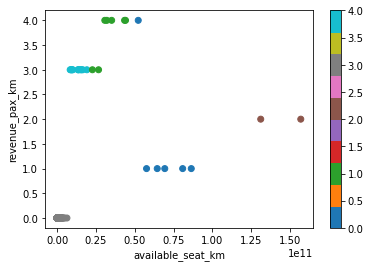

In [53]:
hierarchical = AgglomerativeClustering(n_clusters=5)
hierarchical.fit(flights_all)

plt.scatter(
    flights_all.iloc[:, 0], codes.iloc[:, 1], c=hierarchical.labels_, cmap="tab10"
)
plt.xlabel(flights_all.columns[0])
plt.ylabel(flights_all.columns[1])
plt.colorbar();

## Silhouette

https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html


The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters.

To calculate the Silhouette score for each observation/data point, the following distances need to be found out for each observations belonging to all the clusters:

* Mean distance between the observation and all other data points in the same cluster. This distance can also be called a mean intra-cluster distance. The mean distance is denoted by a
* Mean distance between the observation and all other data points of the next nearest cluster. This distance can also be called a mean nearest-cluster distance. The mean distance is denoted by b

Silhouette score, S, for each sample is calculated using the following formula:

$$S = \frac{(b - a)}{max(a, b)}$$

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [54]:
scaler = StandardScaler()
scaler.fit(flights_all)

X_std = scaler.transform(flights_all)

In [55]:
from yellowbrick.cluster import SilhouetteVisualizer

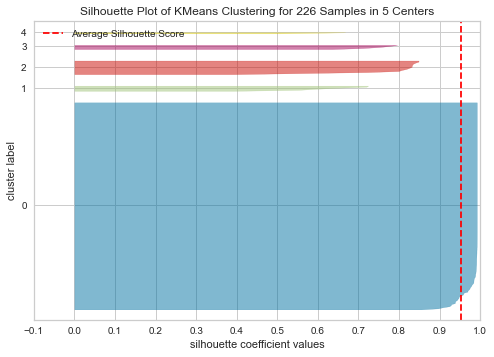

In [56]:
model = KMeans(5).fit(X_std)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X_std)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

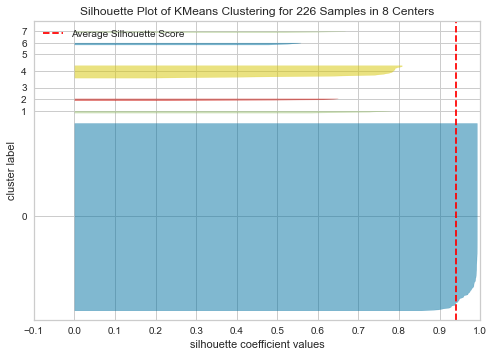

In [57]:
model = KMeans(8).fit(X_std)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")
visualizer.fit(X_std)  # Fit the data to the visualizer
visualizer.show()
# Finalize and render the figure

In [ ]:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html